# I'm losing my mind

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'
datadir = "/home/cfs/mer49/gp/"

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from scipy.special   import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

# This code benefits considerably from using single-precision floating point
# Jax's fft is slow
# Numpy's fft pathologically casts to float64
# Scipy's seems ok
from scipy.fft import *

$$
n' (λ - <y> μ)
$$

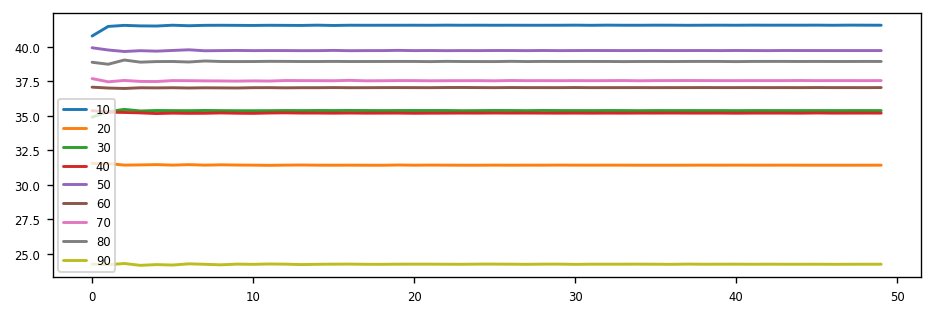

In [135]:
def x(t):
    return cos(t)**2

def λ(x):
    return exp(x)

T  = 50

for nt in arange(10,100,10):
    Δt = T/nt
    t  = linspace(0,T,nt+1)[:-1]
    xt = x(t)
    λt = λ(xt)
    yt = poisson(λt*Δt)

    foo = []
    for nbins in arange(10,1000,20):
        Δx     = 1.0/nbins
        binx   = linspace(0,1,nbins+1)
        binx   = (binx[1:]+binx[:-1])/2
        bin_id = minimum(nbins-1,floor(xt/Δx))

        # Time-units per bin
        N = array([sum(bin_id==i) for i in range(nbins)])
        
        # t-bins/x-bin * time/t_bin = time/x-bin
        Nt = N*Δt

        # Spikes per bin
        K = array([sum(yt[bin_id==i]) for i in range(nbins)])

        # spike/x-bin ÷ time/x-bin = spike/time
        y_bar  = K/Nt
        y_bar[~isfinite(y_bar)] = 0.0

        # λ * time/t-bin is Pr(spike)/t-bin
        # λ has units Pr(spike)/time
        λx     = λ(binx)

        # Log units: lnP(spike) + constant related to time units
        μx     = log(λx)

        # y_bar * μx
        #  spike/time * (lnP(spike) + constant)

        # N*λx
        # time/x-bin Pr(spike)/time = Pr(spike)/x-bin

        # K * μx = N y_bar μx
        # spike/x-bin * (lnP(spike) + constant)

        # does y_bar μx  have same units as   λx? 
        # λx:           spike/time 
        # y_bar μx :    spike/time [lnP(spike) + constant]

        foo+=[sum(Nt*λx - K * μx)]

    plot(foo,label='%s'%nt)
legend()

In [133]:
def x(t):
    return cos(t)**2

def λ(x):
    return exp(x)

T  = 50
nt = 2**14
Δt = T/nt
t  = linspace(0,T,nt+1)[:-1]
xt = x(t)
λt = λ(xt)
yt = poisson(λt*Δt)

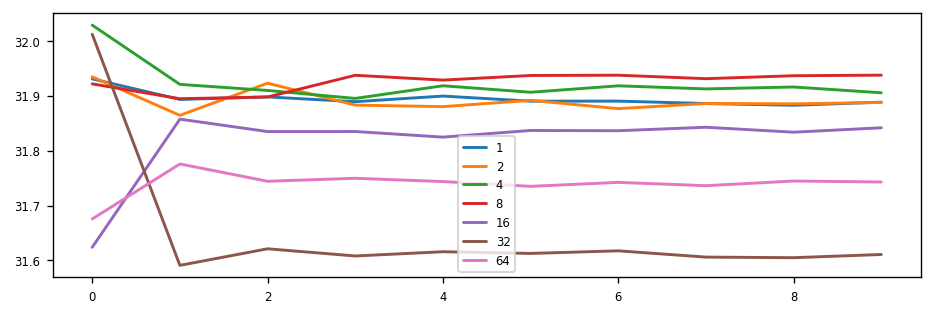

In [134]:
for rebin in [1,2,4,8,16,32,64]:
    
    foo = []
    for nbins in arange(10,1000,100):
        Δx     = 1.0/nbins
        binx   = linspace(0,1,nbins+1)
        binx   = (binx[1:]+binx[:-1])/2
        bin_id = minimum(nbins-1,floor(xt/Δx))

        N = array([sum(bin_id==i) for i in range(nbins)])
        N = N*Δt
        K = array([sum(yt[bin_id==i]) for i in range(nbins)])
        y_bar  = K/N
        y_bar[~isfinite(y_bar)] = 0.0
        λx = λ(binx)
        μx = log(λx)

        foo+=[sum(N*λx - K * μx)]

    plot(foo,label='%s'%rebin)
    
    Δt *= 2
    yt = yt[::2] + yt[1::2]
    λt = λt[::2] + λt[1::2]
    xt = (xt[::2] + xt[1::2])/2
    
legend()

21715.179438880034